```{math}
\newcommand{\detectset}{\mathcal{D}}
\newcommand{\gauss}{\mathcal{N}}
\newcommand{\prob}{\mathbb{P}}
\newcommand{\esp}{\mathbb{E}}
\newcommand{\var}{\mathbb{V}}
\newcommand{\eqsp}{\,}
\newcommand{\Rset}{\mathbb{R}}
\newcommand{\filtdist}{\mathbb{Q}}
\newcommand{\transdist}{\mathbb{M}}
\newcommand{\SMCfiltdist}{\widehat{\filtdist}^{SMC}}
\newcommand{\rmd}{\mathrm{d}}
\newcommand{\predictdist}{\mathbb{L}}
\newcommand{\SMCpredictdist}{\widehat{\predictdist}^{SMC}}
\newcommand{\MCpredictdist}{\widehat{\predictdist}}
\newcommand{\likel}{\mathbb{G}}
\newcommand{\hatN}{\mathsf{\hat{N}}}
\newcommand{\N}{\mathsf{N}}
\newcommand{\Nmis}{\mathsf{\hat{N}_{mis}}}
\newcommand{\Nred}{\mathsf{\hat{N}_{red}}}
\newcommand{\Nfalse}{\mathsf{\hat{N}_{false}}}
\newcommand{\Ntrue}{\mathsf{\hat{N}_{true}}}
\newcommand{\gtlabels}{i \in[\![1, \N]\!]}
\newcommand{\predlabels}{j \in [\![1, \hatN]\!]}
\newcommand{\detre}{\mathsf{DetRe}}
\newcommand{\detpr}{\mathsf{DetPr}}
\newcommand{\assre}{\mathsf{AssRe}}
\newcommand{\asspr}{\mathsf{AssPr}}
\newcommand{\tempwindow}{[\![n-\lfloor \kappa/2 \rfloor, n+\lfloor \kappa/2 \rfloor]\!]}
```

# Macrolitter video counting on river banks with state space models for moving cameras

## Abstract

Litter is a known cause of degradation in marine environments and most of it travels in rivers before reaching the oceans. 
In this paper, we present a novel algorithm to assist waste monitoring along watercourses. 
While several attempts have been made to quantify litter using neural object detection in photographs of floating items, we tackle the more challenging task of counting directly in videos using boat-embedded cameras. 
We rely on multi-object tracking (MOT) but focus on the key pitfalls of false and redundant counts which arise in typical scenarios of poor detection performance. 
Our system only requires supervision at the image level and performs Bayesian filtering via a state space model based on optical flow. 
We present a new open image dataset gathered through a crowdsourced campaign and used to train a center-based anchor-free object detector. 
Realistic video footage assembled by water monitoring experts is annotated and provided for evaluation. 
Improvements in count quality are demonstrated against systems built from state-of-the-art multi-object trackers sharing the same detection capabilities. 
A precise error decomposition allows clear analysis and highlights the remaining challenges.

## Introduction


Litter pollution concerns every part of the globe.
Each year, almost ten thousand million tons of plastic waste is generated, among which 80\% ends up in landfills or in nature {cite}`geyer2017`, notably threatening all of the world’s oceans, seas and aquatic environments {cite}`welden2020,gamage2020`.
Plastic pollution is known to already impact more than 3763 marine species worldwide (see [this](https://litterbase.awi.de/) detailed analysis) with risk of proliferation through the whole food chain.
This accumulation of waste is the endpoint of the largely misunderstood path of trash, mainly coming from land-based sources {cite}`rochman2016`, yet rivers have been identified as a major pathway for the introduction of waste into marine environments {cite}`jambeck2015`.
Therefore, field data on rivers and monitoring are strongly needed to assess the impact of measures that can be taken. The analysis of such field data over time is pivotal to understand the efficiency of the actions implemented such as choosing zero-waste alternatives to plastic, designing new products to be long-lasting or reusable, introducing policies to reduce over-packing.

Different methods have already been tested to monitor waste in rivers: litter collection and sorting on riverbanks {cite}`Bruge2018`, visual counting of drifting litter from bridges {cite}`gonzales2021`, floating booms {cite}`gasperi2014` and nets {cite}`moritt2014`.
All are helpful to understand the origin and typology of litter pollution yet hardly compatible with long term monitoring at country scales.
Monitoring tools need to be reliable, easy to set up on various types of rivers, and should give an overview of plastic pollution during peak discharge to help locate hotspots and provide trends.
Newer studies suggest that plastic debris transport could be better understood by counting litter trapped on river banks, providing a good indication of the local macrolitter pollution especially after increased river discharge {cite}`VanEmmerik2019,VanEmmerik2020`.
Based on these findings, we propose a new method for litter monitoring which relies on videos of river banks directly captured from moving boats.


In this case, object detection with deep neural networks (DNNs) may be used, but new challenges arise. 
First, available data is still scarce. 
When considering entire portions of river banks from many different locations, the variety of scenes, viewing angles and/or light conditions is not well covered by existing plastic litter datasets like {cite}`Proenca2020`, where litter is usually captured from relatively close distances and many times in urban or domestic backgrounds. Therefore, achieving robust object detection across multiple conditions is still delicate.

Second, counting from videos is a different task than counting from independent images, because individual objects will typically appear in several consecutive frames, yet they must only be counted once. This last problem of association has been extensively studied for the multi-object tracking (MOT) task, which aims at recovering individual trajectories for objects in videos. When successful MOT is achieved, counting objects in videos is equivalent to counting the number of estimated trajectories. Deep learning has been increasingly used to improve MOT solutions {cite}`Ciaparrone2020b`. However, newer state-of-the-art techniques require increasingly heavy and costly supervision, typically all object positions provided at every frame. In addition, many successful techniques {cite}`bergmann2019` can hardly be used in scenarios with abrupt and nonlinear camera motion. Finally, while research is still active to rigorously evaluate performance at multi-object *tracking* {cite}`luiten2020`, most but not all aspects of the latter may affect global video counts, which calls for a separate evaluation protocol dedicated to multi-object *counting*.

Our contribution can be summarized as follows.


1. We provide a novel open-source image dataset of macro litter, which includes various objects seen from different rivers and different contexts.
This dataset was produced with a new open-sourced platform for data gathering and annotation developed in conjunction with Surfrider Foundation Europe, continuously growing with more data.
2. We propose a new algorithm specifically tailored to count in videos with fast camera movements.
In a nutshell, DNN-based object detection is paired with a robust state space movement model which uses optical flow to perform Bayesian filtering, while confidence regions built on posterior predictive distributions are used for data association.
This framework does not require video annotations at training time: the multi-object tracking module does not require supervision, only the DNN-based object detection does require annotated images.
It also fully leverages optical flow estimates and the uncertainty provided by Bayesian predictions to recover object identities even when detection recall is low.
Contrary to existing MOT solutions, this method ensures that tracks are stable enough to avoid repeated counting of the same object.
3. We provide a set of video sequences where litter counts are known and depicted in real conditions.
For these videos only, litter positions are manually annotated at every frame in order to carefully analyze performance.
This allows us to build new informative count metrics.
We compare the count performance of our method against other MOT-based alternatives.

A first visual illustation of the second claim is presented via the following code chunks: on three selected frames, we present a typical scenario where our strategy can avoid overcounting the same object (we depict internal workings of our solution against the end result of the competitors).

In [1]:
from myst_nb import glue
import matplotlib.pyplot as plt
import os

from surfnet.prepare_data import download_data
from surfnet.track import default_args as args

# download frames and detections from a given deep detector model
download_data()

# prepare arguments
args.external_detections = True
args.data_dir = 'data/external_detections/part_1_segment_0'
args.output_dir = 'surfnet/results'
args.noise_covariances_path = 'surfnet/data/tracking_parameters'
args.confidence_threshold = 0.5
args.algorithm = 'EKF'
args.ratio = 4
args.display = 0

---Downloading: saved_detections.pickle
---Downloading: saved_frames.pickle


In [2]:
import pickle
import numpy as np

from surfnet.tracking.utils import resize_external_detections, write_tracking_results_to_file
from surfnet.tools.video_readers import FramesWithInfo
from surfnet.tracking.trackers import get_tracker
from surfnet.track import track_video

# Initialize variances
transition_variance = np.load(os.path.join(args.noise_covariances_path, 'transition_variance.npy'))
observation_variance = np.load(os.path.join(args.noise_covariances_path, 'observation_variance.npy'))

# Get tracker algorithm
engine = get_tracker(args.algorithm)

# Open data: detections and frames
with open(os.path.join(args.data_dir, 'saved_detections.pickle'),'rb') as f:
    detections = pickle.load(f)
with open(os.path.join(args.data_dir, 'saved_frames.pickle'),'rb') as f:
    frames = pickle.load(f)

# Create frame reader and resize detections
reader = FramesWithInfo(frames)
detections = resize_external_detections(detections, args.ratio)

# Start tracking, storing intermediate tracklets
results, frame_to_trackers = track_video(reader, detections, args, engine, 
                                         transition_variance, observation_variance, return_trackers=True)

# Write final results
write_tracking_results_to_file(results, ratio_x=args.ratio, ratio_y=args.ratio, output_filename=args.output_dir)

EKF will be used for tracking.
Tracking...


Tracking done.


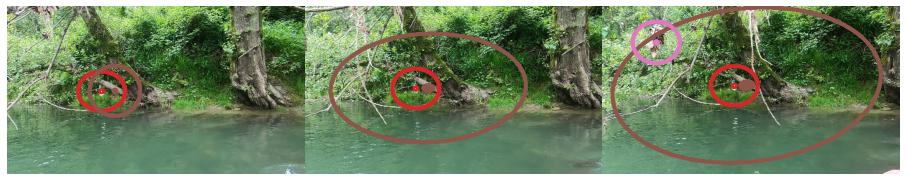

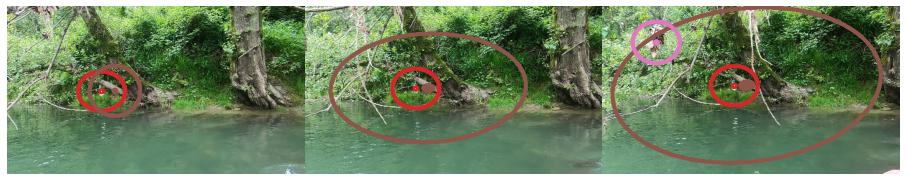

In [3]:
from surfnet.track import build_image_trackers
# Choose a few indices to display (same for our algorithm and SORT)
idxs = [108, 112, 117]
    
considered_frames = [frames[i] for i in idxs]
considered_trackers = [frame_to_trackers[i] for i in idxs]
glue('demo_ours', build_image_trackers(considered_frames, considered_trackers, args, reader), display=False)

```{glue:figure} demo_ours
:name: "demo-ours"
*Our method*: one object (red dot) is correctly detected at every frame and given a consistent identity throughout the sequence with low location uncertainty (red ellipse). Next to it, a false positive detection is generated at the first frame (brown dot) but immediatly lost in the following frames: the associated uncertainty grows fast (brown ellipse). In our solution, this type of track will not be counted. A third correctly detected object (pink) appears in the third frame and begins a new track.

```

In [4]:
## Tracker with SORT 
from collections import defaultdict
import cv2
from sort.sort import track as sort_tracker

print('Tracking with SORT...')
print('--- Begin SORT internal logs')
sort_tracker(detections_dir='data/external_detections', output_dir='sort/results')
print('--- End')

def read_sort_output(filename):
    """ Reads the output .txt of Sort (or other tracking algorithm)
    """
    dict_frames = defaultdict(list)
    with open(filename) as f:
        for line in f:
            items = line[:-1].split(",")
            frame = int(items[0])
            objnum = int(items[1])
            x = float(items[2])
            y = float(items[3])
            dict_frames[int(items[0])].append((objnum, x, y))
    return  dict_frames


def build_image(frames, trackers, image_shape=(135,240), downsampling=2*4):
    """ Builds a full image with consecutive frames and their displayed trackers
    frames: a list of K np.array
    trackers: a list of K trackers. Each tracker is a per frame list of tracked objects
    """
    K = len(frames)
    assert len(trackers) == K
    font = cv2.FONT_HERSHEY_COMPLEX
    output_img=np.zeros((image_shape[0], image_shape[1]*K, 3), dtype=np.uint8)
    object_ids = []
    for tracker in trackers:
        for detection in tracker:
            object_ids.append(detection[0])
    min_object_id = min(object_ids)
    for i in range(K):
        frame = cv2.cvtColor(cv2.resize(frames[i], image_shape[::-1]), cv2.COLOR_BGR2RGB)
        for detection in trackers[i]:
            cv2.putText(frame, f'{detection[0]-min_object_id +1}', (int(detection[1]/downsampling)+10, int(detection[2]/downsampling)+10), font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

        output_img[:,i*image_shape[1]:(i+1)*image_shape[1],:] = frame
    return output_img

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [ ]:
# open sort output
tracker_file = "sort/results/part_1_segment_0.txt"
frame_to_track = read_sort_output(tracker_file)

condisered_frames = [frames[idx] for idx in idxs]
considered_tracks = [frame_to_track[i] for i in idxs]
out_img = build_image(condisered_frames, considered_tracks)
plt.figure(figsize=(15,6))
plt.imshow(out_img)
plt.axis("off");
glue('sort_demo', plt.gcf(), display=False)

```{glue:figure} sort_demo
:name: "demo-sort"

*SORT*: the resulting count is also 2, but both counts arise from tracks generated by the same object, the latter not re-associated at all in the second frame. Additionally, the third object is discarded (in post-processing) by their strategy.
```

## Related works

### AI-automated counting
Counting from images has been an ongoing challenge in computer vision.
Most works can be divided into (i) detection-based methods where objects are individually located for counting (ii) density-based methods where counts are obtained by summing a predicted density map (iii) regression-based methods where counts are directly regressed from input images {cite}`Chattopadhyay`.
While some of these works tackled the problem of counting in wild scenes {cite}`Arteta2016`, most are focused on pedestrian and crowd counting.
Though several works {cite}`wu2020fast,Xiong2017,Miao2019` showed the relevance of leveraging sequential inter-frame information to achieve better counts at every frame, none of these methods actually attempt to produce global video counts.


### Computer vision for macro litter monitoring
Automatic macro litter monitoring in rivers is still a relatively nascent initiative, yet there have already been several attempts at using DNN-based object recognition tools to count plastic trash.
Recently, {cite}`Proenca2020` used a combination of two Convolutional Neural Networks (CNNs) to detect and quantify plastic litter using geospatial images from Cambodia.
In {cite}`Wolf2020`, reliable estimates of plastic density were obtained using Faster R-CNN {cite}`ren2016faster` on images extracted from bridge-mounted cameras.
For underwater waste monitoring, {cite}`vanlieshout2020automated` assembled a dataset with bounding box annotations, and showed promising performance with several object detectors.
They later turned to generative models to obtain more synthetic data from a small dataset {cite}`Hong2020`.
While proving the practicality of deep learning for automatic waste detection in various contexts, these works only provide counts for separate images of photographed litter.
To the best of our knowledge, no solution has been proposed to count litter directly in videos.



### Multi-object tracking
Multi-object tracking usually involves object detection, data association and track management, with a very large number of methods already existing before DNNs {cite}`luo2021`.
MOT approaches now mostly differ in the level of supervision they require for each step: until recently, most successful methods (like {cite}`Bewley2016`) have been detection-based, i.e.
involving only a DNN-based object detector trained at the image level and coupled with an unsupervised data association step.
In specific fields such as pedestrian tracking or autonomous driving, vast datasets now provide precise object localisation and identities throughout entire videos {cite}`Caesar2020, Dendorfer2020`.
Current state-of-the-art methods leverage this supervision via deep visual feature extraction {cite}`Wojke2018,Zhanga` or even self-attention {cite}`Chu2021` and graph neural networks {cite}`Wang2021`.
For these applications, motion prediction may be required, yet well-trained appearance models are usually enough to deal with detection failures under simple motion, therefore the linear constant-velocity assumption often prevails ({cite}`Ciaparrone2020b`).

In the case of macrolitter monitoring, however, available image datasets are still orders of magnitude smaller, and annotated video datasets do not exist at all.
Even more so, real shooting conditions induce chaotic movements on the boat-embedded cameras.
A close work of ours is that of {cite}`Fulton2018`, who paired Kalman filtering with optical flow to yield fruit count estimates on entire video sequences captured by moving robots.
However, their video footage is captured at night with consistent lighting conditions, backgrounds are largely similar across sequences, and camera movements are less challenging.
In our application context, we find that using MOT for the task of counting objects requires a new movement model, to take into account missing detections and large camera movements.

## Datasets for training and evaluation
Our main dataset of annotated images is used to train the object detector.
Then, only for evaluation purposes, we provide videos with annotated object positions and known global counts.
Our motivation is to avoid relying on training data that requires this resource-consuming process.

### Images
#### Data collection
With help from benevolents, we compile photographs of litter stranded on river banks after increased river discharge, shot directly from kayaks navigating at varying distances from the shore.
Images span multiple rivers with various levels of water current, on different seasons, mostly in southwestern France.
The resulting pictures depict trash items under the same conditions as the video footage we wish to count on, while spanning a wide variety of backgrounds, light conditions, viewing angles and picture quality.

#### Bounding box annotation
For object detection applications, the images are annotated using a custom online platform where each object is located using a bounding box.
In this work, we focus only on litter counting without classification, however the annotated objects are already classified into specific categories which are described in [](trash-categories-image).

A few samples are depicted below:

In [ ]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO


def draw_bbox(image, anns, ratio):
    """
    Display the specified annotations.
    """
    for ann in anns:
        [bbox_x, bbox_y, bbox_w, bbox_h] = (ratio*np.array(ann['bbox'])).astype(int)
        cv2.rectangle(image, (bbox_x,bbox_y),(bbox_x+bbox_w,bbox_y+bbox_h), color=(0,0,255),thickness=3)

    return image

dir = 'surfnet/data/images'

ann_dir = os.path.join(dir,'annotations')
data_dir = os.path.join(dir,'images')
ann_file = os.path.join(ann_dir, 'subset_of_annotations.json')
coco = COCO(ann_file)

imgIds = np.array(coco.getImgIds())
print('{} images loaded'.format(len(imgIds)))

for imgId in imgIds:
    plt.figure()
    image = coco.loadImgs(ids=[imgId])[0]
    try:
        image = Image.open(os.path.join(data_dir,image['file_name']))
        # Rotation of the picture in the Exif tags
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation]=='Orientation':
                break
        
        exif = image._getexif()
        if exif is not None:
            if exif[orientation] == 3:
                image=image.rotate(180, expand=True)
            elif exif[orientation] == 6:
                image=image.rotate(270, expand=True)
            elif exif[orientation] == 8:
                image=image.rotate(90, expand=True)

    except (AttributeError, KeyError, IndexError):
        # cases: image don't have getexif
        pass
    image = cv2.cvtColor(np.array(image.convert('RGB')),  cv2.COLOR_RGB2BGR)
    annIds = coco.getAnnIds(imgIds=[imgId])
    anns = coco.loadAnns(ids=annIds)
    h,w = image.shape[:-1]
    target_h = 1080
    ratio = target_h/h
    target_w = int(ratio*w) 
    image = cv2.resize(image,(target_w,target_h))
    image = draw_bbox(image,anns,ratio)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

### Video sequences
#### Data collection
For evaluation, an on-field study was conducted with 20 volunteers to manually count litter along three different riverbank sections in April 2021, on the Gave d'Oloron near Auterrive (Pyrénées-Atlantiques, France), using kayaks.
The river sections, each 500 meters long, were precisely defined for their differences in background, vegetation, river current, light conditions and accessibility (see [this section](video-dataset-appendix) for aerial views of the shooting site and details on the river sections).
In total, the three videos amount to 20 minutes of footage at 24 frames per second (fps) and a resolution of 1920x1080 pixels.


#### Track annotation
On video footage, we manually recovered all visible object trajectories on each river section using an online video annotation tool (more details [here](video-dataset-appendix) for the precise methodology).
From that, we obtained a collection of distinct object tracks spanning the entire footage.

## Optical flow-based counting via Bayesian filtering and confidence regions

Our counting method is divided into several interacting blocks.
First, a detector outputs a set of predicted positions for objects in the current frame.
The second block is a tracking module designing consistent trajectories of potential objects within the video.
At each frame, a third block links the successive detections together using confidence regions provided by the tracking module, proposing distinct tracks for each object.
A final postprocessing step only keeps the best tracks which are enumerated to yield the final count.

### Detector
#### Center-based anchor-free detection
In most benchmarks, the prediction quality of object attributes like bounding boxes is often used to  improve tracking.
For counting, however, point detection is theoretically enough and advantageous in many ways.
First, to build large datasets, a method which only requires the lightest annotation format may benefit from more data due to annotation ease.
Second, contrary to previous popular methods {cite}`ren2016faster` involving intricate mechanisms for bounding box prediction, center-based and anchor-free detectors {cite}`Zhou2019, Law` only use additional regression heads which can simply be removed for point detection.
Adding to all this, {cite}`Zhanga` highlight conceptual and experimental reasons to favor anchor-free detection in tracking-related tasks.

\
For these reasons, we use a stripped version of CenterNet {cite}`Zhou2019` where offset and bounding box regression heads are discarded to output bare estimates of center positions on a coarse grid.
An encoder-decoder network takes an input image $I \in [0,1]^{w \times h \times 3}$ (an RGB image of width $w$ and height $h$), and produces a heatmap $\hat{Y} \in [0,1]^{\lfloor w/p\rfloor \times \lfloor h/p\rfloor}$ such that  $\hat{Y}_{xy}$ is the probability that $(x,y)$ is the center of an object ($p$ being a stride coefficient).
At inference, peak detection and thresholding are applied to $\hat{Y}$, yielding the set of detections.
The bulk of this detector relies on the DLA34 architecture {cite}`fisher2017`.
In a video, for each frame $I_n \in [0,1]^{w \times h \times 3}$ (where $n$ indexes the frame number), the detector outputs a set $\detectset_n = \{z_n^i\}_{1 \leq i \leq D_n}$ where each $z_n^i = (x_n^i,y_n^i)$ specifies the coordinates of one of the $D_n$ detected objects.

(detector-training)=
#### Training
Training the detector is done similarly as in {cite}`Proenca2020`.
 For every image, the corresponding set $\mathcal{B} = \{(c^w_i,c^h_i,w_i,h_i)\}_{1 \leq i\leq B}$ of $B$ annotated bounding boxes -- *i.e.* a center $(c^w_i,c^h_i)$, a width $w_i$ and a height $h_i$-- is rendered into a ground truth heatmap $Y \in [0,1]^{{\lfloor w/p\rfloor \times \lfloor h/p\rfloor}}$ by applying kernels at the bounding box centers and taking element-wise maximum.
For all $1 \leq x \leq w/p$, $1 \leq y \leq h/p$, the ground truth at $(x,y)$ is

$$
  Y_{xy} =  \max\limits_{1\leq i\leq B}\left(\exp\left\{-\frac{(x-c_i^w)^2+(y-c_i^h)^2}{2\sigma^2_i}\right\}\right),
$$

where $\sigma_i$ is a parameter depending on the size of the object.
Training the detector is done by minimizing a penalty-reduced weighted focal loss

$$
\mathcal{L}(\hat{Y},Y) = -\sum_{x,y} \gamma_{xy}^\beta\left(1-\hat{p}_{xy}\right)^\alpha \log{\left(\hat{p}_{xy}\right)},
$$

where $\alpha$, $\beta$ are hyperparameters and

$$
(\hat{p}_{xy},\gamma_{xy}) = \left\{
    \begin{array}{ll}
        (\hat{Y}_{xy},1) & \mbox{if } Y_{xy} = 1, \\
        (1 - \hat{Y}_{xy},1 - Y_{xy}) & \mbox{otherwise}
    \end{array}
\right.
$$

(bayesian-tracking)=
### Bayesian tracking with optical flow 

#### Optical flow

Between two timesteps $n-1$ and $n$, the optical flow $\Delta_n$ is a mapping  satisfying the following consistency constraint {cite}`paragios2006`:

$$
\widetilde{I}_n[u] = \widetilde{I}_{n-1}[u+\Delta_n(u)],
$$

where, in our case, $\widetilde{I}_n$ denotes the frame $n$ downsampled to dimensions $\lfloor w/p\rfloor \times \lfloor h/p\rfloor$ and $u = (x,y)$ is a coordinate on that grid.
To estimate $\Delta_n$, we choose a simple unsupervised Gunner-Farneback algorithm which does not require further annotations, see {cite}`farneback2003two` for details.

#### State-space model

Using optical flow as a building block, we posit a state-space model where estimates of $\Delta_n$ are used as a time and state-dependent offset for the state transition.
Let $(X_k)_{k \geq 1}$ and $(Z_k)_{k \geq 1}$ be the true (but hidden) and observed (detected) positions of a target object in $\Rset^2$, respectively.
Considering the optical flow value associated with $X_{k-1}$ on the discrete grid of dimensions $\lfloor w/p\rfloor \times \lfloor h/p\rfloor$, write

```{math}
:label: state-transition-eq
X_k = X_{k-1} + \Delta_k(\lfloor X_{k-1} \rfloor) + \eta_k
```

and

$$
Z_k = X_k + \varepsilon_k,
$$

where $(\eta_k)_{k\geq 1}$ are i.i.d. centered Gaussian random variables with covariance matrix $Q$ independent of $(\varepsilon_k)_{k\geq 1}$ i.i.d. centered Gaussian random variables with covariance matrix $R$.
In the following, $Q$ and $R$ are assumed to be diagonal, and are hyperparameters set to values given in [](covariance-matrices)

#### Approximations of the filtering distributions
Denoting $u_{1:k} = (u_1,\ldots,u_k)$ for any $k$ and sequence $(u_i)_{i \geq 0}$, Bayesian filtering aims at computing the conditional distribution of $X_k$ given $Z_{1:k}$, referred to as the filtering distribution.
In the case of linear and Gaussian state space models, this distribution is known to be Gaussian, and Kalman filtering allows to update exactly the posterior mean $\mu_k = \esp[X_k|Z_{1:k}]$ and posterior variance matrix $\Sigma_k = \var[X_k|Z_{1:k}]$.
This algorithm and its extensions are prevalent and used extensively in time-series and sequential-data analysis.
As the transition model proposed in [](state-transition-eq) is nonlinear, Kalman updates cannot be implemented and solving the target tracking task requires resorting to alternatives.
Many solutions have been proposed in the literature such as extended Kalman filters (EKF), unscented Kalman filters (UKF) or Sequential Monte Carlo (SMC) methods, see {cite}`sarkka2013bayesian` and references therein.
Although UKF and SMC have been widely studied, such sample-based solutions are more computationally intensive, especially in settings where many objects have to be tracked and false positive detections involve unnecessary sampling steps. The following EKF approximation of model [](state-transition-eq) is found to be computationnaly cheaper and as robust for our data:

$$
X_k = X_{k-1} + \Delta_k(\lfloor \mu_{k-1} \rfloor) + \nabla_x\Delta_k(\lfloor \mu_{k-1} \rfloor)(X_{k-1}-\mu_{k-1}) + \eta_k
$$ 

This allows the implementation of Kalman updates. For completeness, we present [here](impact-algorithm-appendix) an SMC-based solution, discuss the empirical differences and use-cases where the latter might be a more relevant choice. 
In any case, the state-space model naturally accounts for missing observations, as the contribution of $\Delta_k$ in every transition ensures that each filter can cope with arbitrary inter-frame motion to keep track of its target. 

#### Generating potential object tracks
The full MOT algorithm consists of a set of single-object trackers following the previous model, but each provided with distinct observations at every frame.
These separate filters provide track proposals for every object detected in the video.

(data-association)=
### Data association using confidence regions
Throughout the video, depending on various conditions on the incoming detections, existing trackers must be updated (with or without a new observation) and others might need to be created.
This traditional Multiple Hypothesis Tracking (MHT) setup requires a third party data association block to link the incoming detections with the correct filters.
At the frame $n$, a set of $L_n$ Bayesian filters track previously seen objects and a new set of detections $\mathcal{D}_n$ is provided by the detector.
Denote by $1 \leq \ell \leq L_n$ the index of each filter at time $n$, and by convention write $Z^\ell_{1:n-1}$  the previous observed positions associated with index $\ell$ (even if no observation is available at some past times for that object).
Let $\rho \in (0,1)$ be a confidence level.

1. For every detected object $z_n^i \in \detectset_n$ and every filter $\ell$, compute $P(i,\ell) = \prob(Z_n^\ell \in V_\delta(z_n^i)\mid Z^\ell_{1:n-1})$ where $V_\delta(z)$ is the neighborhood of $z$ defined as the squared area of width $2\delta$ centered on $z$ (see [this appendix](confidence-regions-appendix) for exact computations).
2. Using the Hungarian algorithm {cite}`kuhn`, compute the assignment between detections and filters with $P$ as cost function, but discarding associations $(i,\ell)$ having $P(i,\ell) < \rho$.
Formally, $\rho$ represents the level of a confidence region centered on detections and we use $\rho = 0.5$.
Denote $a_{\rho}$ the resulting assignment map defined as $a_{\rho}(i) = \ell$ if $z_n^i$ was associated with the $\ell$-th filter, and $a_{\rho}(i) = 0$ if $z_n^i$ was not associated with any filter.
3. For $1 \leq i \leq D_n$, if $a_{\rho}(i) = \ell$, use $z_n^i$ as a new observation to update the $\ell$-th filter.
If $a_{\rho}(i) = 0$, create a new filter initialized from the prior distribution, i.e.
sample the true location as a Gaussian random variable with mean $z_n^i$ and variance $R$.
4. For all filters $\ell'$ which were not provided a new observation, update only the predictive law of $X^{\ell'}_{n}$ given $Z^{\ell'}_{1:n-1}$.

In other words, we seek to associate filters and detections by maximising a global cost built from the predictive distributions of the available filters, but an association is only valid if its corresponding predictive probability is high enough.
Though the Hungarian algorithm is a very popular algorithm in MOT, it is often used with the Euclidean distance or an Intersection-over-Union (IoU) criterion.
Using confidence regions for the distributions of $Z_n$ given $Z_{1:(n - 1)}$ instead allows to naturally include uncertainty in the decision process.
Note that we deactivate filters whose posterior mean estimates lie outside the image subspace in $\Rset^2$.

A visual depiction of the entire tracking (from detection to final association) is provided below. 

```{figure} assets/diagram.png
---
name: diagram
---
Visual representation of the tracking pipeline.
```

### Counting
At the end of the video, the previous process returns a set of candidate tracks.
For counting purposes, we find that simple heuristics can be further applied to filter out tracks that do not follow actual objects.
More precisely, we observe that tracks of real objects usually contain more (i) observations and (ii) streams of uninterrupted observations.
Denote by $T_\ell = \left\{n \in \mathbb{N} \mid \exists  z \in \detectset_n,  Z_n^{\ell} = z\right\}$ all timesteps where the $\ell$-th object is observed.
To discard false counts according to (i) and (ii), we compute the moving average $M_\ell^\kappa$ of $1_{n \in T_\ell}$ defined on $[\![\min(T_\ell), \max(T_\ell)]\!]$ using windows of size $\kappa$, and build $T_\ell^\kappa = \left\{n \in T_\ell \mid M_\ell^\kappa[n] > \nu\right\}$ .
Defining $\mathcal{N} = \left\{\ell \mid |T_\ell^\kappa| > \tau\right\}$, the final object count is $|\mathcal{N}|$.
We choose $\nu = 0.6$ while $\kappa,\tau$ are optimized for best count performance (see [here](tau-kappa-appendix) for a more comprehensive study).

## Metrics for MOT-based counting

Counting in videos using embedded moving cameras is not a common task, and as such it requires a specific evaluation protocol to understand and compare the performance of competing methods.
First, not all MOT metrics are relevant, even if some do provide insights to assist evaluation of count performance.
Second, considering only raw counts on long videos gives little information on which of the final counts effectively arise from well detected objects.

### Count-related MOT metrics

Popular MOT benchmarks usually report several sets of metrics such as ClearMOT {cite}`bernardin2008` or IDF1 {cite}`RistaniSZCT16` which can account for different components of tracking performance.
Recently, {cite}`Proenca2020` built the so-called HOTA metrics that allow separate evaluation of detection and association using the Jaccard index.
The following components of their work are relevant to our task (we provide equation numbers in the original paper for formal definitions).

#### Detection
First, when considering all frames independently, traditional detection recall ($\detre$, eq.
23) and precision ($\detpr$, eq.
24) can be computed to assess the capabilities of the object detector.
In classical object detection, those metrics are the main target.
In our context, as the first step of the system, this framewise performance impacts the difficulty of counting.
However, we must keep in mind that these metrics are computed framewise and might not guarantee anything at a video scale.
The next points illustrate that remark.


1. If both $\detre$ and $\detpr$ are very high, objects are detected at nearly all frames and most detections come from actual objects.
Therefore, robustness to missing observations is high, but even in this context computing associations may fail if camera movements are nontrivial.
2. For an ideal tracking algorithm which never counts individual objects twice and does not confuse separate objects in a video, a detector capturing each object for only one frame could theoretically be used.
Thus, low $\detre$ could theoretically be compensated with robust tracking.
3. If our approach can rule out faulty tracks which do not follow actual objects, then good counts can still be obtained using a detector generating many false positives.
Again, this suggests that low $\detpr$ may allow decent counting performance.


#### Association

HOTA association metrics are built to measure tracking performance irrespective of the detection capabilities, by comparing predicted tracks against true object trajectories.
In our experiments, we compute the Association recall ($\assre$, eq. 26) and the Association Precision ($\asspr$, eq. 27).
In brief, a low $\asspr$ implies that several objects are often mingled into only one track, resulting in undercount.
A low $\assre$ implies that single objects are often associated with multiple tracks.
If no method is used to discard redundant tracks this results in overcount.
Conversely, association precision ($\asspr$) measures how exclusive tracks are to each object (it decreases whenever a track covers multiple objects).
Again, it is useful to reconsider and illustrate the meaning of these metrics in the context of MOT-based counting.
Litter items are typically well separated on river banks, thus predicted tracks are not expected to interfere much.
This suggests that reaching high $\asspr$ on our footage is not challenging.
Contrarily, $\assre$ is a direct measurement of the capability of the tracker to avoid producing multiple tracks despite missing detections and challenging motion.
A high $\assre$ therefore typically avoids multiple counts for the same object, which is a key aspect of our work.

Nonetheless, association metrics are only computed for predicted tracks which can effectively be matched with ground truth tracks.
Consequently, $\assre$ does not account for tracks predicted from streams of false positive detections generated by the detector (e.g.
arising from rocks, water reflections, etc).
Since such tracks induce false counts, a tracker which produces the fewest is better, but MOT metrics do not measure it.

### Count metrics
Denoting by $\hatN$ and $\N$ the respective predicted and ground truth counts for the validation material, the error $\hatN - \N$ is misleading as no information is provided on the quality of the predicted counts.
Additionally, results on the original validation footage do not measure the statistical variability of the proposed estimators.

#### Count decomposition
Define $\gtlabels$ and $\predlabels$ the labels of the annotated ground truth tracks and the predicted tracks, respectively.
At evaluation, we assign each predicted track to either none or at most one ground truth track, writing $j \rightarrow \emptyset$ or $j \rightarrow i$ for the corresponding assignments.
Denote $A_i = \{\predlabels \mid j \rightarrow i\}$ the set of predicted tracks assigned to the $i$-th ground truth track.
We define:


1. $\Ntrue = \sum_{i=1}^{\N} 1_{|A_i| > 0}$ the number of ground truth objects successfully counted.
2. $\Nred = \sum_{i=1}^{\N} |A_i| - \Ntrue$ the number of redundant counts per ground truth object.
3. $\Nmis = \N - \Ntrue$ the number of ground truth objects that are never effectively counted.
4. $\Nfalse = \sum_{j=1}^{\hatN} 1_{j \rightarrow \emptyset}$ the number of counts which cannot be associated with any ground truth object and are therefore considered as false counts.


Using these metrics provides a much better understanding of $\hatN$ as 

$$
\hatN = \Ntrue + \Nred + \Nfalse
$$ 
while $\Nmis$ completely summarises the number of undetected objects.
Note that these metrics and the associated decomposition are only defined if the previous assignment between predicted and ground truth tracks can be obtained.
In our case, predicted tracks never overlap with several ground truth tracks (because true objects are well separated), and therefore this assignment is straightforward.

#### Statistics
Since the original validation set comprises only a few unequally long videos, only absolute results are available.
Splitting the original sequences into shorter independent sequences of equal length allows to compute basic statistics.
For any quantity $\hatN_\bullet$ defined above, we provide $(\hat{\mu}_{\hatN_\bullet}, \hat{\sigma}_{\hatN_\bullet})$ the associated empirical means and standard deviations computed on the set of short sequences.

## Experiments
We denote by $S_1$, $S_2$ and $S_3$ the three river sections of the evaluation material and split the associated footage into independent segments of 30 seconds. 

To demonstrate the benefits of our work, we select two multi-object trackers and build competing counting systems from them. Our first choice is SORT {cite}`Bewley2016`, which relies on Kalman filtering with velocity updated using the latest past estimates of object positions.Similar to our system, it only relies on image supervision for training, and though DeepSORT {cite}`Wojke2018` is a more recent alternative with better performance, the associated deep appearance network cannot be used without additional video annotations. FairMOT {cite}`Zhanga`, a more recent alternative, is similarly intended for use with video supervision but allows self-supervised training using only an image dataset. Built as a new baseline for MOT, it combines linear constant-velocity Kalman filtering with visual features computed by an additional network branch and extracted at the position of the estimated object centers, as introduced in CenterTrack {cite}`zhou2020`. We choose FairMOT to compare our method to a solution based on deep visual feature extraction.

Similar to our work, FairMOT uses CenterNet for the detection part and the latter is therefore trained as in [](detector-training). We train it using hyperparameters from the original paper. The detection outputs are then shared between all counting methods, allowing fair comparison of counting performance with a given object detector. We run all experiments at 12fps, an intermediate framerate to capture all objects while reducing the computational burden. Note that both SORT and FairMOT use custom postprocessing methods to filter out implausible tracks, and we leave these mechanisms untouched.

#### Detection
In the following section, we present the performance of the trained detector.
Having annotated all frames of the evaluation videos, we directly compute $\detre$ and $\detpr$ on those instead of a test split of the image dataset used for training.
This allows realistic assessment of the detection quality of our system on true videos that may include blurry frames or artifacts caused by strong motion.
We observe low $\detre$, suggesting that objects are only captured on a fraction of the frames they appear on.
To better focus on count performance in the next sections, we remove segments that do not generate any correct detection: performance on the remaining footage is increased and given by $\detre^{*}$ and $\detpr^{*}$.

In [ ]:
from IPython.display import display
import pandas as pd

indices = [0,16,19,27]
fps = 12
fps_str = f'{fps}fps'

gt_dir_short = f'TrackEval/data/gt/surfrider_short_segments_{fps_str}/surfrider-test' 
eval_dir_short = f'TrackEval/data/trackers/surfrider_short_segments_{fps_str}' 

long_segments_names = ['part_1_1','part_1_2','part_2','part_3']

def get_det_values(index_start=0, index_stop=-1):

    results_for_det = pd.read_csv(os.path.join(eval_dir_short,'surfrider-test','ours_EKF_1_12fps_v0_tau_0','pedestrian_detailed.csv'))
    results_det = results_for_det.loc[:,['DetRe___50','DetPr___50', 'HOTA_TP___50','HOTA_FN___50','HOTA_FP___50']].iloc[index_start:index_stop]
    results_det.columns = ['hota_det_re','hota_det_pr','hota_det_tp','hota_det_fn','hota_det_fp']
    hota_det_re = results_det['hota_det_re']
    hota_det_pr = results_det['hota_det_pr']
    hota_det_tp = results_det['hota_det_tp']
    hota_det_fn = results_det['hota_det_fn']
    hota_det_fp = results_det['hota_det_fp']

    denom_hota_det_re = hota_det_tp + hota_det_fn 
    denom_hota_det_pr = hota_det_tp + hota_det_fp 

    hota_det_re_cb = (hota_det_re * denom_hota_det_re).sum() / denom_hota_det_re.sum()
    hota_det_pr_cb = (hota_det_pr * denom_hota_det_pr).sum() / denom_hota_det_pr.sum()

    return [f'{100*hota_det_re_cb:.1f}', f'{100*hota_det_pr_cb:.1f}']
    
def get_table_det():

    table_values = [get_det_values(index_start, index_stop) for (index_start, index_stop) in zip(indices[:-1],indices[1:])]
    table_values.append(get_det_values())
    return pd.DataFrame(table_values)

table_det = get_table_det()
table_det.columns = ['DetRe*','DetPr*']
table_det.index = ['S1','S2','S3','All']
display(table_det)

#### Counts
We now compare our method against FairMOT and SORT with the count-related tracking metrics and count decompositions defined in the previous section.
We run our algorithm with $\kappa = 7,\tau = 5$, values obtained after a simple hyperparameter study described in [](image-dataset-appendix).

Across all videos and all methods, we report $\asspr$ between 98.6 and 99.2 which shows that this application context is unconcerned with tracks spanning multiple ground truth objects, therefore we do not conduct a more detailed interpretation of $\asspr$ values.
The remaining and most important results are summarized in the tables below. For detailed visualisation of the results, we also plot the error decompositions for all sequences.
The first row reveals the unreliability of the off-the-shelf self-supervised version of FairMOT (FMOT) as a counting system.
Though being the most recent, the lack of video supervision prevents this method from learning usable visual features.
This results in poor association performance (the lowest $\assre$ of all methods) and a largely impractical and unstable number of incorrect or redundant counts.
However, we observe for FairMOT that many false tracks only last for one frame.
To mitigate the previous remarks, we apply our own postprocessing with $\kappa=1,\tau=1$ and refer to the modified procedure as FairMOT* (FMOT*).
Our solution brings substantial improvements by largely decreasing the amount of incorrect and redundant counts.
For all sequences combined, we report values for $\Nfalse$ and $\Nred$ respectively 41\% and 84\% lower than those of SORT (the next best method) and our algorithm even completely removes redundant counts on the footage covering $S_2$ and $S_3$.
Improvements in count quality can be traced back to the robustness of our tracking system with an increase of 12\% in $\assre$ over SORT.
Notably, footage on $S_2$ (which includes strong motion) is only correctly handled by our method, while competitors show significant drops in $\assre$.
It is worth noting that a significant number of objects remain uncounted ($\Nmis$ is high), a pitfall shared by all methods.
Our counting method also shows a statistically more stable and predictable behaviour.
For almost all metrics of interest, we lower the associated standard deviations by a significant margin, which highlights the improved consistency across the different videos and therefore a greater applicability in real-life situations.
The increased stability of all error types results in more stable overall $\hatN$, as we report $\hat{\sigma}_{\hatN} = 2.4$ for our method against 3.3 and 3.5 for SORT and FairMOT*, respectively.

In [ ]:
def get_summary(results, index_start=0, index_stop=-1):

    results = results.loc[:,['Correct_IDs___50','Redundant_IDs___50','False_IDs___50','Missing_IDs___50','Fused_IDs___50', 'GT_IDs','HOTA_TP___50','AssRe___50']].iloc[index_start:index_stop]

    results.columns = ['correct','redundant','false','missing','mingled','gt','hota_tp','ass_re']

    ass_re = results['ass_re']
    hota_tp = results['hota_tp']

    ass_re_cb = (ass_re * hota_tp).sum() / hota_tp.sum()

    redundant = results['redundant']
    false = results['false']
    missing = results['missing']
    # mingled = results['mingled'] 
    gt = results['gt']
    count_error = false + redundant - missing

    summary = dict()
    summary['missing'], summary['missing_mean'], summary['missing_std'] = f'{missing.sum()}',f'{missing.mean():.1f}',f'{missing.std():.1f}'
    summary['false'], summary['false_mean'], summary['false_std'] = f'{false.sum()}', f'{false.mean():.1f}', f'{false.std():.1f}'
    summary['redundant'], summary['redundant_mean'], summary['redundant_std'] = f'{redundant.sum()}', f'{redundant.mean():.1f}', f'{redundant.std():.1f}'
    summary['ass_re_cb'], summary['ass_re_mean'], summary['ass_re_std'] = f'{100*ass_re_cb:.1f}',f'{100*ass_re.mean():.1f}',f'{100*ass_re.std():.1f}'
    summary['gt'] = f'{gt.sum()}'
    summary['count_error'], summary['count_error_mean'], summary['count_error_std'] = f'{count_error.sum()}',f'{count_error.mean():.1f}',f'{count_error.std():.1f}'

    return summary 


def get_summaries(results, sequence_names):

    summaries = dict()

    for (sequence_name, index_start, index_stop) in zip(sequence_names, indices[:-1],indices[1:]):

        summaries[sequence_name] = get_summary(results, index_start, index_stop)
    
    summaries['All'] = get_summary(results)

    return summaries



summaries = []
for tracker_name in ['fairmot_cleaned', 'sort','ours_EKF_1_12fps_v2_7_tau_5']:
    results = pd.read_csv(os.path.join(eval_dir_short,'surfrider-test',tracker_name,'pedestrian_detailed.csv'))
    sequence_names = ['S1','S2','S3']
    summaries.append(pd.DataFrame(get_summaries(results, sequence_names))[:10].T)


fairmot_star, sort, ours = summaries

nmis = '$\hat{\mathsf{N}}_{mis}$'
mu_nmis ='$\hat{\mu}_{\hat{\mathsf{N}}_{mis}}$'
sigma_nmis = '$\hat{\sigma}_{\hat{\mathsf{N}}_{mis}}$'

nfalse = '$\hat{\mathsf{N}}_{false}$'
mu_nfalse = '$\hat{\mu}_{\hat{\mathsf{N}}_{false}}$'
sigma_nfalse = '$\hat{\sigma}_{\hat{\mathsf{N}}_{false}}$'

nred =  '$\hat{\mathsf{N}}_{red}$'
mu_nred = '$\hat{\mu}_{\hat{\mathsf{N}}_{red}}$'
sigma_nred = '$\hat{\sigma}_{\hat{\mathsf{N}}_{red}}$'
ass_re = '$\mathsf{AssRe}$'
rows = ['S1','S2','S3','All']
columns = ['nmis', 'mu_nmis', 'sigma_nmis', 'nfalse', 'mu_nfalse', 'sigma_nfalse', 'nred', 'mu_nred', 'sigma_nred', 'ass_re']

for summary in summaries:    
    summary.columns = columns

for name, summary in zip(['fairmot_star','sort','ours'], summaries):
    for row in rows:
        for col in columns: 
            glue(f'{name}_{row}_{col}', summary.loc[row,col], display=False)

|     |   $\hat{\mathsf{N}}_{mis}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{mis}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{mis}}$ |   $\hat{\mathsf{N}}_{false}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{false}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{false}}$ |   $\hat{\mathsf{N}}_{red}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{red}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{red}}$ |  $\mathsf{AssRe}$ |
|:----|-------:|----------:|-------------:|---------:|------------:|---------------:|-------:|----------:|-------------:|-------------:|
| S1  |     {glue:text}`fairmot_star_S1_nmis` |       {glue:text}`fairmot_star_S1_mu_nmis` |       {glue:text}`fairmot_star_S1_sigma_nmis` |       {glue:text}`fairmot_star_S1_nfalse` |         {glue:text}`fairmot_star_S1_mu_nfalse` |            {glue:text}`fairmot_star_S1_sigma_nfalse` |      {glue:text}`fairmot_star_S1_nred` |       {glue:text}`fairmot_star_S1_mu_nred` |       {glue:text}`fairmot_star_S1_sigma_nred` | {glue:text}`fairmot_star_S1_ass_re` |
| S2  |      {glue:text}`fairmot_star_S2_nmis` |       {glue:text}`fairmot_star_S2_mu_nmis` |       {glue:text}`fairmot_star_S2_sigma_nmis` |       {glue:text}`fairmot_star_S2_nfalse` |         {glue:text}`fairmot_star_S2_mu_nfalse` |            {glue:text}`fairmot_star_S2_sigma_nfalse` |      {glue:text}`fairmot_star_S2_nred` |       {glue:text}`fairmot_star_S2_mu_nred` |       {glue:text}`fairmot_star_S2_sigma_nred` | {glue:text}`fairmot_star_S2_ass_re` |
| S3  |     {glue:text}`fairmot_star_S3_nmis` |       {glue:text}`fairmot_star_S3_mu_nmis` |       {glue:text}`fairmot_star_S3_sigma_nmis` |       {glue:text}`fairmot_star_S3_nfalse` |         {glue:text}`fairmot_star_S3_mu_nfalse` |            {glue:text}`fairmot_star_S3_sigma_nfalse` |      {glue:text}`fairmot_star_S3_nred` |       {glue:text}`fairmot_star_S3_mu_nred` |       {glue:text}`fairmot_star_S3_sigma_nred` | {glue:text}`fairmot_star_S3_ass_re` |
| All |     {glue:text}`fairmot_star_All_nmis` |       {glue:text}`fairmot_star_All_mu_nmis` |       {glue:text}`fairmot_star_All_sigma_nmis` |       {glue:text}`fairmot_star_All_nfalse` |         {glue:text}`fairmot_star_All_mu_nfalse` |            {glue:text}`fairmot_star_All_sigma_nfalse` |      {glue:text}`fairmot_star_All_nred` |       {glue:text}`fairmot_star_All_mu_nred` |       {glue:text}`fairmot_star_All_sigma_nred` | {glue:text}`fairmot_star_All_sigma_nred` |

|     |   $\hat{\mathsf{N}}_{mis}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{mis}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{mis}}$ |   $\hat{\mathsf{N}}_{false}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{false}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{false}}$ |   $\hat{\mathsf{N}}_{red}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{red}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{red}}$ |  $\mathsf{AssRe}$  |
|:----|-------:|----------:|-------------:|---------:|------------:|---------------:|-------:|----------:|-------------:|-------------:|
| S1  |     {glue:text}`sort_S1_nmis` |       {glue:text}`sort_S1_mu_nmis` |       {glue:text}`sort_S1_sigma_nmis` |       {glue:text}`sort_S1_nfalse` |         {glue:text}`sort_S1_mu_nfalse` |            {glue:text}`sort_S1_sigma_nfalse` |      {glue:text}`sort_S1_nred` |       {glue:text}`sort_S1_mu_nred` |       {glue:text}`sort_S1_sigma_nred` | {glue:text}`sort_S1_ass_re` |
| S2  |      {glue:text}`sort_S2_nmis` |       {glue:text}`sort_S2_mu_nmis` |       {glue:text}`sort_S2_sigma_nmis` |       {glue:text}`sort_S2_nfalse` |         {glue:text}`sort_S2_mu_nfalse` |            {glue:text}`sort_S2_sigma_nfalse` |      {glue:text}`sort_S2_nred` |       {glue:text}`sort_S2_mu_nred` |       {glue:text}`sort_S2_sigma_nred` | {glue:text}`sort_S2_ass_re` |
| S3  |     {glue:text}`sort_S3_nmis` |       {glue:text}`sort_S3_mu_nmis` |       {glue:text}`sort_S3_sigma_nmis` |       {glue:text}`sort_S3_nfalse` |         {glue:text}`sort_S3_mu_nfalse` |            {glue:text}`sort_S3_sigma_nfalse` |      {glue:text}`sort_S3_nred` |       {glue:text}`sort_S3_mu_nred` |       {glue:text}`sort_S3_sigma_nred` | {glue:text}`sort_S3_ass_re` |
| All |     {glue:text}`sort_All_nmis` |       {glue:text}`sort_All_mu_nmis` |       {glue:text}`sort_All_sigma_nmis` |       {glue:text}`sort_All_nfalse` |         {glue:text}`sort_All_mu_nfalse` |            {glue:text}`sort_All_sigma_nfalse` |      {glue:text}`sort_All_nred` |       {glue:text}`sort_All_mu_nred` |       {glue:text}`sort_All_sigma_nred` | {glue:text}`sort_All_sigma_nred` |

|     |   $\hat{\mathsf{N}}_{mis}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{mis}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{mis}}$ |   $\hat{\mathsf{N}}_{false}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{false}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{false}}$ |   $\hat{\mathsf{N}}_{red}$ |   $\hat{\mu}_{\hat{\mathsf{N}}_{red}}$ |   $\hat{\sigma}_{\hat{\mathsf{N}}_{red}}$ |  $\mathsf{AssRe}$  |
|:----|-------:|----------:|-------------:|---------:|------------:|---------------:|-------:|----------:|-------------:|-------------:|
| S1  |     {glue:text}`ours_S1_nmis` |       {glue:text}`ours_S1_mu_nmis` |       {glue:text}`ours_S1_sigma_nmis` |       {glue:text}`ours_S1_nfalse` |         {glue:text}`ours_S1_mu_nfalse` |            {glue:text}`ours_S1_sigma_nfalse` |      {glue:text}`ours_S1_nred` |       {glue:text}`ours_S1_mu_nred` |       {glue:text}`ours_S1_sigma_nred` | {glue:text}`ours_S1_ass_re` |
| S2  |      {glue:text}`ours_S2_nmis` |       {glue:text}`ours_S2_mu_nmis` |       {glue:text}`ours_S2_sigma_nmis` |       {glue:text}`ours_S2_nfalse` |         {glue:text}`ours_S2_mu_nfalse` |            {glue:text}`ours_S2_sigma_nfalse` |      {glue:text}`ours_S2_nred` |       {glue:text}`ours_S2_mu_nred` |       {glue:text}`ours_S2_sigma_nred` | {glue:text}`ours_S2_ass_re` |
| S3  |     {glue:text}`ours_S3_nmis` |       {glue:text}`ours_S3_mu_nmis` |       {glue:text}`ours_S3_sigma_nmis` |       {glue:text}`ours_S3_nfalse` |         {glue:text}`ours_S3_mu_nfalse` |            {glue:text}`ours_S3_sigma_nfalse` |      {glue:text}`ours_S3_nred` |       {glue:text}`ours_S3_mu_nred` |       {glue:text}`ours_S3_sigma_nred` | {glue:text}`ours_S3_ass_re` |
| All |     {glue:text}`ours_All_nmis` |       {glue:text}`ours_All_mu_nmis` |       {glue:text}`ours_All_sigma_nmis` |       {glue:text}`ours_All_nfalse` |         {glue:text}`ours_All_mu_nfalse` |            {glue:text}`ours_All_sigma_nfalse` |      {glue:text}`ours_All_nred` |       {glue:text}`ours_All_mu_nred` |       {glue:text}`ours_All_sigma_nred` | {glue:text}`ours_All_sigma_nred` |

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
for ax, title, tracker_name in zip(axes, ['FairMOT*','SORT','Ours'] ,['fairmot_cleaned', 'sort', 'ours_EKF_1_12fps_v2_7_tau_5']):
    results = pd.read_csv(os.path.join(eval_dir_short,'surfrider-test',tracker_name,'pedestrian_detailed.csv'))
    results = results.loc[:,['Redundant_IDs___50','False_IDs___50','Missing_IDs___50']].iloc[:-1]
    results.columns = ['redundant', 'false', 'missing']
    results.loc[:,'missing'] = - results.loc[:,'missing']
    results.columns = ['$\hat{\mathsf{N}}_{red}$', '$\hat{\mathsf{N}}_{false}$', '$-\hat{\mathsf{N}}_{mis}$']
    results.plot(ax = ax, kind='bar', stacked=True, color=['orange', 'red', 'black'], sharey=True, title=title, xlabel='Sequence nb')

<!-- ```{glue:} fairmot_star_tracking_results
``` -->

## Practical impact and future goals

We successfully tackled video object counting on river banks, in particular issues which could be adressed independently of detection quality.
Moreover the methodology developed to assess count quality enables us to precisely highlight the challenges that pertain to video object counting on river banks.
Conducted in coordination with Sufrider Foundation Europe, an NGO specialized on water preservation, our work marks an important milestone in a broader campaign for macrolitter monitoring and is already being used in a production version of a monitoring system.
That said, large amounts of litter items are still not detected.
Solving this problem is largely a question of augmenting the object detector training dataset through crowdsourced images.
A [specific annotation platform](https://www.trashroulette.com) is online, thus the amount of annotated images is expected to continuously increase, while training is provided to volunteers collecting data on the field to ensure data quality.
Finally, several expeditions on different rivers are already underway and new video footage is expected to be annotated in the near future for better evaluation.
All data is made freely available.
Future goals include downsizing the algorithm, a possibility given the architectural simplicity of anchor-free detection and the relatively low computational complexity of EKF.
In a citizen science perspective, a fully embedded version for portable devices will allow a larger deployment.
The resulting field data will help better understand litter origin, allowing to model and predict litter density in non surveyed areas.
Correlations between macro litter density and environmental parameters will be studied (e.g., population density, catchment size, land use and hydromorphology).
Finally, our work naturally benefits any extension of macrolitter monitoring in other areas (urban, coastal, etc) that may rely on a similar setup of moving cameras.

# Supplements

(image-dataset-appendix)=
## Details on the image dataset

### Categories

In this work, we do not seek to precisely predict the proportions of the different types of counted litter.
However, we build our dataset to allow classification tasks.
Though litter classifications built by experts already exist, most are based on semantic rather than visual features and do not particularily consider the problem of class imbalance, which makes statistical learning more delicate.
In conjunction with water pollution experts, we therefore define a custom macrolitter taxonomy which balances annotation ease and pragmatic decisions for computer vision applications.
This classification, depicted in {numref}`trash-categories-image` can be understood as follows.


1. We define a set of frequently observed classes that annotaters can choose from, divided into: 

    - Classes for rigid and easily recognisable items which are often observed and have definite shapes
    - Classes for fragmented objects which are often found along river banks but whose aspects are more varied

2. We define two supplementary categories used whenever the annotater cannot classify the item they are observing in an image using classes given in 1.


    - A first category is used whenever the item is clearly identifiable but its class is not proposed.
This will ensure that our classification can be improved in the future, as images with items in this category will be checked regularly to decide whether a new class needs to be created
    - Another category is used whenever the annotater doesn't understand the item they are seeing.
Images containing items denoted as such will not be used for applications involving classifiction.


```{figure} assets/trash_categories.png
---
height: 400px
name: trash-categories-image
---
Trash categories defined to facilitate porting to a counting system that allows trash identification
```


(video-dataset-appendix)=
## Details on the evaluation videos

### River segments 

In this section, we provide further details on the evaluation material.
{numref}`river-sections` shows the setup and positioning of the three river segments $S_1$, $S_2$ and $S_3$ used to evaluate the methods.
The segments differ in the following aspects.

- Segment 1: Medium current, high and dense vegetation not obstructing vision of the right riverbank from watercrafts, extra objects installed before the field experiment.
- Segment 2: High current, low and dense vegetation obstructing vision of the right riverbank from watercrafts.
- Segment 3: Medium current, high and little vegetation not obstructing vision  of the left riverbank from watercrafts.



```{figure} assets/river_sections.png
---
height: 400px
name: river-sections
---
Aerial view of the three river segments of the evaluation material
```


### Track annotation protocol
To annotate tracks on the evaluation sequences, we used the online tool "CVAT" which allows to locate bounding boxes on video frames and propagate them in time.
The following items provide further details on the exact annotation process.

- Object tracks start whenever a litter item becomes fully visible and identifiable by the naked eye.
- Positions and sizes of objects are given at nearly every second of the video with automatic interpolation for frames in-between: this yields clean tracks with precise positions at 24fps.
- We do not provide inferred locations when an object is fully occluded, but tracks restart with the same identity whenever the object becomes visible again.
- Tracks stop whenever an object becomes indistinguishable and will not reappear again.

(tracking-module-appendix)=
## Implementation details for the tracking module

(covariance-matrices)=
### Covariance matrices for state and observation noises

In our state-space model, $Q$ models the noise associated to the movement model we posit in [](bayesian-tracking) involving optical flow estimates, while $R$ models the noise associated to the observation of the true position via our object detector.
An attempt to estimate the diagonal values of these matrices was the following.


- To estimate $R$, we computed a mean $L_2$ error between the known positions of objects and the associated predictions by the object detector, for images in our training dataset.
- To estimate $Q$, we built a small synthetic dataset of consecutive frames taken from videos, where positions of objects in two consecutive frames are known.
We computed a mean $L_2$ error between the known positions in the second frame and the positions estimated by shifting the positions in the first frame with the estimated optical flow values.


This led to $R_{00} = R_{11} = 1.1$, $Q_{00} = 4.7$ and $Q_{11} = 0.9$, for grids of dimensions $\lfloor w/p\rfloor \times \lfloor h/p\rfloor = 480 \times 270$.
All other coefficients were not estimated and supposed to be 0.


An important remark is that though we use these values in practise, we found that tracking results are largely unaffected by small variations of $R$ and $Q$.
As long as values are meaningful relative to the image dimensions and the size of the objects, most noise levels show relatively similar performance.

(confidence-regions-appendix)=
### Computing the confidence regions


In words, $P(i,\ell)$ is the mass in $V_\delta(z_n^i) \subset \Rset^2$ of the probability distribution of $Z_n^\ell$ given $Z_{1:n-1}^\ell$.
Denote with $\predictdist_n^\ell$ this distribution.
When EKF is used, $\predictdist_n^\ell$ is a multivariate Gaussian with mean $\mathbb{E}[Z_k^\ell|Z_{1:k-1}^\ell]$ and covariance matrix $\mathbb{V}[Z_k^\ell|Z_{1:k-1}^\ell]$.
In $\Rset^2$, values of the cumulative distribution function (cdf) of a multivariate Gaussian distribution are easy to compute.
Denote with $F_n^\ell$ the cdf of $\predictdist_n^\ell$.
If $V_\delta(z)$ is a squared neighborhood of size $\delta$ and centered on $z=(x,y) \in \Rset^2$, then

$$
\predictdist_n^{\ell}(V_\delta(z)) = F_n^\ell(x+\delta,y+\delta) + F_n^\ell(x-\delta,y-\delta) - \left[F_n^\ell(x+\delta,y-\delta) + F_n^\ell(x-\delta,y+\delta)\right]
$$

This allows easy computation of $P(i,\ell) = \predictdist_n^\ell(V_\delta(z_n^i))$.

(tau-kappy-appendix)=
### Influence of $\tau$ and $\kappa$

An understanding of $\kappa$, $\tau$ and $\nu$ can be stated as follows.
For any track, given a value for $\kappa$ and $\nu$, an observation at time $n$ is only kept if there are also $\nu \cdot \kappa$ observations in the temporal window of size $\kappa$ that surrounds $n$ (windows are centered around $n$ except at the start and end of the track).
The track is only counted if the remaining number of observations is strictly higher than $\tau$.
At a given $\nu > 0.5$, $\kappa$ and $\tau$ must be chosen jointly to decrease $\Nfalse$ as much as possible without increasing $\Nmis$ (true objects become uncounted if tracks are discarded too easily).

In the following code cell, we plot the error decomposition of the counts for several values of $\kappa$ and $\tau$ with $\nu=0.6$.
For all values of $\tau$, increasing $\kappa$ decreases $\Nfalse$, but a low $\Nmis$ at the highest $\kappa = 7$ is only preserved for $\tau=5$, which motivates our choice of $(\kappa, \tau) = (7,5)$.
As a byproduct, this choice positively affects $\Nred$.

In [ ]:
tau_values = [i for i in range(4,10)]
versions = ['v0','v2_3','v2_5','v2_7']
fig, (ax0, ax1, ax2) = plt.subplots(3,1)

for version in versions:
    tracker_names = [f'ours_EKF_1_12fps_{version}_tau_{tau}' for tau in tau_values]
    all_results = {tracker_name: pd.read_csv(os.path.join(eval_dir_short,'surfrider-test',tracker_name,'pedestrian_detailed.csv')).iloc[[-1]] for tracker_name in tracker_names}

    n_missing = []
    n_false = []
    n_redundant = []
    for tracker_name, tracker_results in all_results.items():
        missing = (tracker_results['GT_IDs'] - tracker_results['Correct_IDs___50'])[27]
        false = tracker_results['False_IDs___50'][27]
        redundant = tracker_results['Redundant_IDs___50'][27]

        n_missing.append(missing)
        n_false.append(false)
        n_redundant.append(redundant)

    ax0.scatter(tau_values, n_missing, label=version)
    ax0.plot(tau_values, n_missing, label=version, linestyle='dashed')
    # ax0.set_xlabel('$\\tau$')
    ax0.set_ylabel('$N_{missing}$')

    ax1.scatter(tau_values, n_false, label=version)
    ax1.plot(tau_values, n_false, label=version, linestyle='dashed')

    # ax1.set_xlabel('$\\tau$')
    ax1.set_ylabel('$N_{incorrect}$')

    ax2.scatter(tau_values, n_redundant, label=version)
    ax2.plot(tau_values, n_redundant, label=version, linestyle='dashed')
    ax2.set_xlabel('$\\tau$')
    ax2.set_ylabel('$N_{redundant}$')


plt.tight_layout()

(impact-algorithm-appendix)=
## Impact of the filtering algorithm 
An advantage of the data association method proposed in [](data-association) is that it is very generic and does not constrain the tracking solution to any particular choice of filtering algorithm.
As for EKF, UKF implementations are already available to compute the distribution of $Z_k$ given $Z_{1:k-1}$ and the corresponding confidence regions (see [](tracking-module-appendix] above).
We propose a solution to compute this distribution when SMC is used, and performance comparisons between the EKF, UKF and SMC versions of our trackers are discussed.

### SMC-based tracking

Denote $\filtdist_k$ the filtering distribution of the HMM $(X_k,Z_k)_{k \geq 1}$  (omitting the dependancy in observations for notation ease).
 Using a set of samples $\{X_k^i\}_{1 \leq i \leq N}$ and importance weights $\{w_k^i\}_{1 \leq i \leq N}$, SMC methods build an approximation of the following form:

$$
\SMCfiltdist_k = \sum_{i=1}^N w_k^i \delta_{X_k^i} \approx \filtdist_k \eqsp.
$$ 
Contrary to EKF and UKF, the distribution $\mathbb{L}_k$ of $Z_k$ given $Z_{1:k-1}$ is not directly available but can be obtained via an additional Monte Carlo sampling step.
Marginalizing over $(X_{k-1}$, $X_k)$ and using the conditional independence properties of HMMs, we decompose $\mathbb{L}_k$ using the conditional state transition $\transdist_k(x,\rmd x')$ and the likelihood of $Y_k$ given $X_k$, denoted by $\likel_k(x, \rmd z)$:

$$
\mathbb{L}_k = \int \int \likel_k(x', \cdot)\transdist_k(x, \rmd x')\filtdist_{k-1}(\rmd x) \eqsp.
$$ 

Replacing $\filtdist_k$ with $\SMCfiltdist_k$ into the previous equation yields

$$
\SMCpredictdist_k = \sum_{k=1}^N w_k^i \int \likel_k(x,\cdot) \transdist_k(X_k^i, \rmd x)  \eqsp.
$$

In our model, the state transition is Gaussian and thererefore easy to sample from.
Thus an approximated predictive distribution $\MCpredictdist_k$ can be obtained using Monte Carlo estimates built from random samples $\{X_k^{i,j}\}_{1 \leq i \leq N}^{1 \leq j \leq M}$ drawn using the state transition, ie.
such that $\prob(X_k^{i,j} \in \rmd x) = \transdist_k(X_k^i,\rmd x)$.
This leads to

$$
\MCpredictdist_k = \sum_{i=1}^N \sum_{j=1}^M w_k^i \likel_k(X_k^{i,j},\cdot) \eqsp.
$$ 

Since the observation likelihood is also Gaussian, $\MCpredictdist_k$ is a Gaussian mixture, thus values of $\MCpredictdist_k(\mathsf{A})$ for any $\mathsf{A} \subset \Rset^2$ can be computed by applying the tools in [](tracking-module) to all mixture components.
Similar to EKF and UKF, this approximated predictive distribution is used to recover object identities via $\MCpredictdist_n^{\ell}(V_\delta(z_n^i))$ computed for all incoming detections $\detectset_n = \{z_n^i\}_{1 \leq i \leq D_n}$ and each of the $1 \leq \ell \leq L_n$ filters, where $\MCpredictdist_n^{\ell}$ is the predictive distribution associated with the $\ell$-th filter.


### Performance comparison

In theory, sampling-based methods like UKF and SMC are better suited for nonlinear state-space models like the one we propose in [](bayesian-tracking}.
However, we observe very few differences in count results when upgrading from EKF to UKF to SMC.
In practise, there is no difference at all between our EKF and UKF implementations, which show strictly identical values for $\Ntrue$, $\Nfalse$ and $\Nred$.
For the SMC version, values for $\Nfalse$ and $\Nred$ improve by a very small amount (2 and 1, respectively), but $\Nmis$ is slightly worse (one more object missed), and these results depend loosely on the number of samples used to approximate the filtering distributions and the number of samples for the Monte Carlo scheme.
Therefore, our motion estimates via the optical flow $\Delta_n$ prove very reliable in our application context, so much that EKF, though suboptimal, brings equivalent results.
This comforts us into keeping it as a faster and computationally simpler option.
That said, this conclusion might not hold in scenarios where camera motion is even stronger, which was our main motivation to develop a flexible tracking solution and to provide implementations of UKF and SMC versions.
This allows easier extension of our work to more challenging data.

```{bibliography}
:style: unsrt
```